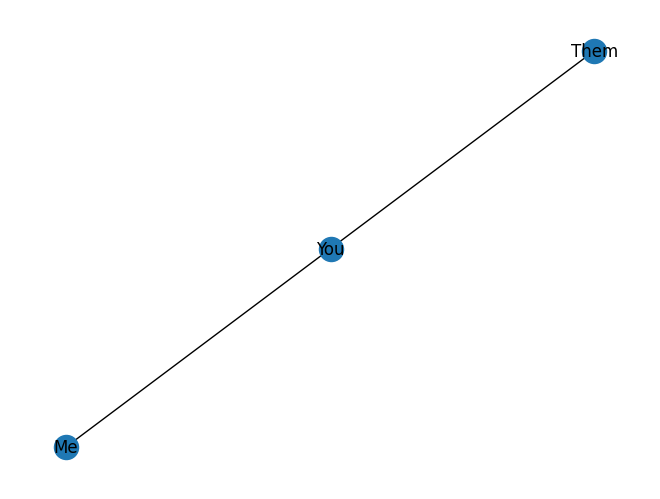

Mr.
Dr.
Miss
Ind.
Mx.
Mrs.
Misc.
Ms.
😟


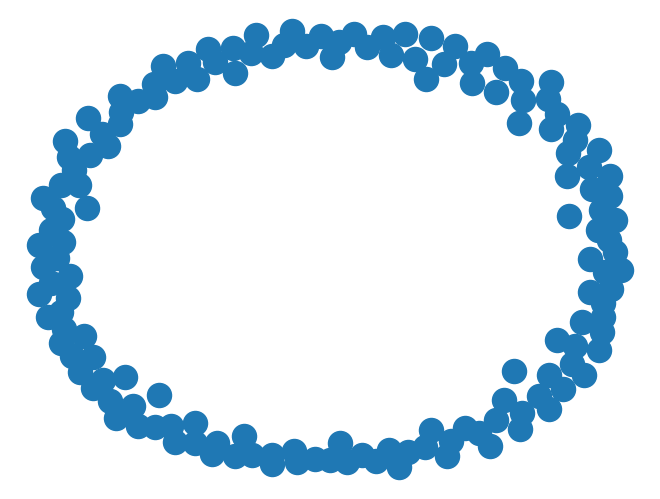

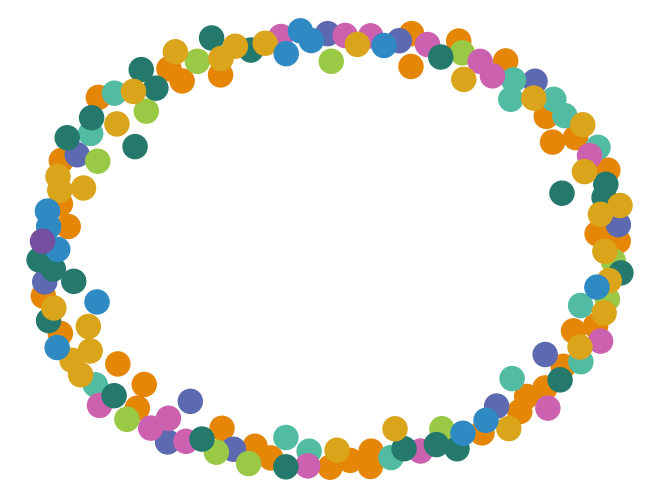

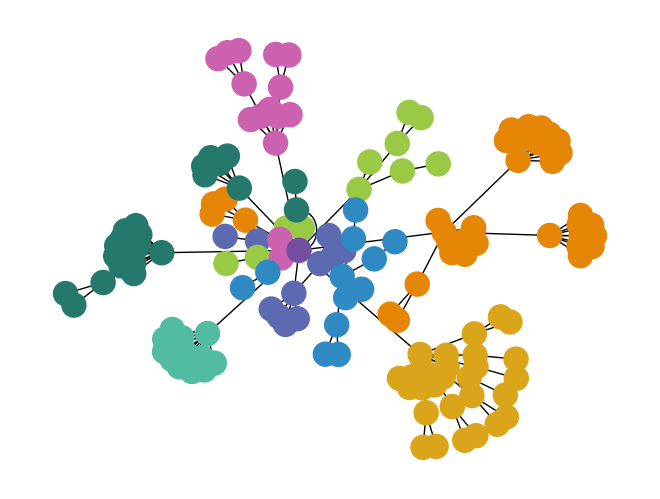

In [2]:
%run "../Part 1 - The Graph/Solution.ipynb"

Now we can take extra info (attributes) of each person (node) and map those onto nodes. This will allow us to connect people *through* common attributes, and not just through relationships like "reporting structure" or "hierarchy"

In [8]:
from itertools import chain
from more_itertools import always_iterable

def add_nodes_from_attributes(G: nx.Graph, *, attribute:str, default=[], flag:str):
    """Find all of the unique values for the given attribute and add those as nodes
    
    Add a flag to that node to make it easy to identify compared to the `people=True` nodes from earlier"""


In [ ]:
        
add_nodes_from_attributes(G, attribute="languages", flag="language")
add_nodes_from_attributes(G, attribute="city", flag="city")
add_nodes_from_attributes(G, attribute="tz", flag="timezone", default="")

Let's add the edges in now connecting people to the app/language nodes!

In [9]:
from more_itertools import always_iterable

def just_people(G):
    """A node filter function, returning only nodes that have the `people="True"` flag"""
    return lambda n: G.nodes()[n].get("person")

def add_edges_from_attributes(G:nx.Graph, *, attribute:str, weight:int=1):
    """Add edges to the graph connecting people to the attributes they hold"""
    

In [10]:
add_edges_from_attributes(G, attribute="languages")
add_edges_from_attributes(G, attribute="tz")
add_edges_from_attributes(G, attribute="city")
#add_edges_from_attributes(G, attribute="manager")

This should look interesting! We used a **force-directed layout** to draw the graph, meaning that the edges between nodes are **pulling** the nodes together in order until they find an equilibrium point. This also takes into account the weights we applied to edges, with higher weighed edges behaving like springs with higher spring constants

In [11]:
px_plot_nx(G, height=800, hover_name="label", color="team", size="rank", with_edges=False, template="plotly_dark")

## Extras

We can visually look for closeness above, or do it algorithmically. An `ego_graph` will show you all of the other nodes that are within `radius` steps from yourself (through any edge)

```python
someone = list(G.nodes)[0]
ego = nx.ego_graph(G, someone, undirected=True, radius=2)
ego_people = nx.subgraph_view(ego, filter_node=just_people(G)).nodes()
nx.draw_networkx(ego, nodelist=ego_people)
```

This information is also easy to recover from the Graph itself

```python

peoplenodes = nx.subgraph_view(ego, filter_node=just_people)
connectivity = nx.all_pairs_node_connectivity(ego, nbunch=peoplenodes)
connectivity
```

We can also look at where nodes get placed in our force-directed graph and look for closeness there

```python
import numpy as np
import xarray as xr

positions = {
    name: pos for name, pos in nx.spring_layout(G).items() if name in peoplenodes
}
positions = xr.DataArray(
    list(positions.values()),
    coords={"person": list(positions), "position": ["x", "y"]},
    dims=["person", "position"],
    attrs=dict(description="Node locations in a force-directed layout"),
)
positions
```

We can now do some matrix math to find the pairwise euclidean distances between each node!

```python
similarities = np.sqrt(((positions - positions.rename(person="person2"))**2).sum("position"))
similarities.name = "distance"
similarities
```

```python
friends = similarities.sel(person="Lucas").sortby(similarities.sel(person="Lucas"))
friends[:2].person2
```

But this is the same approach (in spirit) to representing a graph as vectors in N-dimensional space (only here we do just 2-dim). A more common approach is to use `node2vec` and then look for closeness in the vectors